# Hurricane Irma Damage Assessment Modeling

In this notebook we develop a multilinear and decision tree model to assess damages from hurricane Irma.

Our dataset consists of weather, socioeconomic, and Twitter parameters from 49 counties in Florida during Irma. The dependent variable is the amount of federal aid from FEMA that a county received, `dmg`.

In [1]:
%cd '/content/drive/My Drive/Colab Notebooks/disaster_assessment/irma_modeling'

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

df = pd.read_csv('irma.csv')
df.set_index(keys='county',inplace=True)
df

/content/drive/My Drive/Colab Notebooks/disaster_assessment/irma_modeling


,maxwind_mean,maxwind_peak,precip_total,precip_peak,mhi,poverty_rate,poverty_pop,population,gdp,twt_total,twt_peak,dmg
county,,,,,,,,,,,,
Alachua County,12.453333,35.0,18.25,11.39,45230,21.2,53816,269956,11912080,182,39,9.306765e+06
Baker County,10.200000,24.1,9.21,7.06,51856,15.3,3900,28355,472948,1,1,1.360526e+06
Bradford County,12.453333,35.0,18.25,11.39,44997,19.1,4533,27732,532487,4,1,3.246248e+06
Brevard County,14.900000,41.0,4.69,2.25,52596,12.4,72303,596849,20453753,354,71,3.192891e+07
Broward County,15.680000,49.0,10.44,4.11,56702,13.1,252288,1951260,96591919,2036,382,1.329551e+08
Charlotte County,17.666667,44.1,1.69,0.76,51583,10.8,19300,184998,3966314,72,20,6.625988e+06
Citrus County,14.313333,33.0,13.18,5.97,43147,14.4,20654,147929,3335110,67,13,5.568339e+06
Clay County,10.200000,24.1,9.21,7.06,65375,9.9,20889,216072,3976007,53,8,1.219590e+07
Collier County,18.866667,63.9,5.12,4.20,66709,11.7,43075,378488,16124953,231,63,6.194133e+07


## Feature Selection

We have 11 features, but do we really need them all? Especially when we only have 49 data points. As the following heat map shows, a lot of the variables correlate with each other, forming distinct clusters.

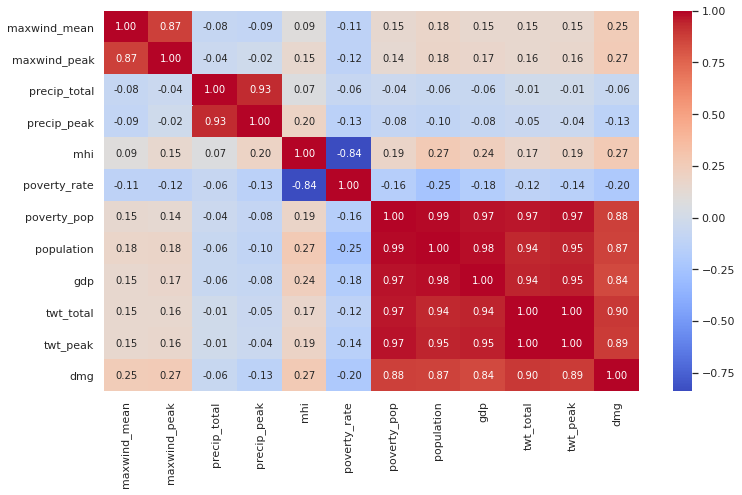

In [2]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),
            annot=True,
            fmt = '.2f',
            cmap='coolwarm')
plt.show()

We can identify these clusters as follows:

- Wind: `maxwind_mean`, `maxwind_peak`
- Precipitation: `precip_total`, `precip_peak`
- Socioeconomic: `mhi`, `poverty_rate`
- Population: `poverty_pop`, `population`, `gdp`, `twt_total`, `twt_peak`

Our goal is to predict `dmg`. To avoid high multicollinearity among our predictors, let's simply take one variable from each cluster. We'll pick the ones with the strongest correlation to `dmg`. This gives us `maxwind_peak`, `precip_peak`, `mhi`, `twt_total`.

Let's verify that these variables are independent of eacher using **Variance Inflation Factor (VIF)**. The VIF of an independent variable is a measure of how much its variation can be attributed to other independent variables. The higher it is, the more redundant the (not so) independent variable is. VIF is calculated as follows:

$$ VIF = \frac{1}{1 - R^2_i} $$

where $R_i^2$ is the $R^2$ of the multilinear regression model of the $i^{\text{th}}$ independent variable using the other independent variables as predictors. Why not just use $R^2_i$ to measure redundancy? One intuition is that the inverse relationship will harshly penalize smaller and smaller values of $1 - R^2_i$ (the so-called **tolerance**).

Let's compute the VIF for each of the four predictors we're using:

In [3]:
from sklearn.preprocessing import robust_scale
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.api as sm

# preprocess data
features = ['maxwind_peak', 'precip_peak', 'mhi', 'twt_total']
df = df[features+['dmg']]

X = df[features].apply(robust_scale)
X_vif = sm.add_constant(X.values) # for the vif func

vif_dict = {}
for f in features:
    idx = features.index(f) # need this for vif func
    vif_dict[f] = vif(X_vif, idx)
vif_dict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'maxwind_peak': 1.1609234512973168,
 'mhi': 1.0514008951220526,
 'precip_peak': 1.0447003684876797,
 'twt_total': 1.097731476287398}

This is good! The typical threshhold for VIF's is 10, sometimes 5. All the VIF's calculated were close to 1, indicating that the variables are very much independent of each other.

## Modeling
Now that we have settled on our features, let's model our data. We will try out a linear regression and decision tree model and see which comes out best.

In [4]:
from sklearn.model_selection import train_test_split

Y = robust_scale(df['dmg'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.1,
                                                    random_state = 0,
                                                    shuffle = True)

### Linear Regression


In [5]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg_model = linreg.fit(X_train, Y_train)

### Decision Tree
Now let's find the optimal decision tree model.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state = 0)
param_grid = {'min_impurity_decrease': [1e-2, 1e-1, 0.2, 0.3],
              'max_features': [None, 'sqrt'],
              'max_depth': [1, 2, 3, 4, 5, 6]}

dt_model = GridSearchCV(tree, param_grid, scoring='r2')
dt_model.fit(X_train, Y_train)
dt_model.best_params_

{'max_depth': 2, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01}

### Model Selection
Let's see how the models stack up on their train/test results

In [7]:
linreg_train_score = linreg_model.score(X_train, Y_train)
linreg_test_score = linreg_model.score(X_test, Y_test)
dt_train_score = dt_model.score(X_train, Y_train)
dt_test_score = dt_model.score(X_test, Y_test)

print("===== Linear Regression r2 Scores =====")
print("Train: %.2f" % linreg_train_score)
print("Test: %.2f" % linreg_test_score)
print()
print("===== Decision Tree r2 Scores =====")
print("Train: %.2f" % dt_train_score)
print("Test: %.2f" % dt_test_score)

===== Linear Regression r2 Scores =====
Train: 0.56
Test: 0.79

===== Decision Tree r2 Scores =====
Train: 0.73
Test: 0.18


The linear regression model seems to generalize well, the test score is *higher* than the train score. The decision tree model on the other hand, is severely overfit.

Let's plot the predictions from each model against the true values of the dependent variable and see if this gives any insight.

Linear regression r2 = 0.76
Decision Tree r2 = 0.48


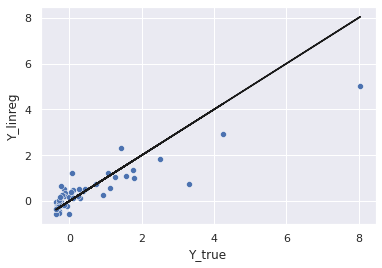

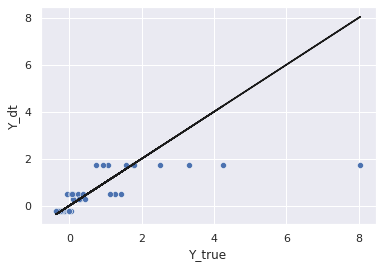

In [8]:
from sklearn.metrics import r2_score

Y_linreg = linreg_model.predict(X)
Y_dt = dt_model.predict(X)


Y_arr = np.array([Y, Y_linreg, Y_dt]).T
Y_df = pd.DataFrame(data=Y_arr,
                    columns = ['Y_true', 'Y_linreg', 'Y_dt'])

sns.scatterplot(data = Y_df,
                x = 'Y_true',
                y = 'Y_linreg')
plt.plot(Y, Y, 'k-')

plt.figure()
sns.scatterplot(data = Y_df,
                x = 'Y_true',
                y = 'Y_dt')
plt.plot(Y, Y, 'k-')

print("Linear regression r2 = %.2f" % r2_score(Y, Y_linreg))
print("Decision Tree r2 = %.2f" % r2_score(Y, Y_dt))

Both models appear to struggle to accurately predict large values of Y (i.e. `dmg`), especially the decision tree model.

How good are the models for "low" damage? Let's cut off the Y_true past 2 and see how the models compare.

Linear regression r2 = 0.57
Decision Tree r2 = 0.70


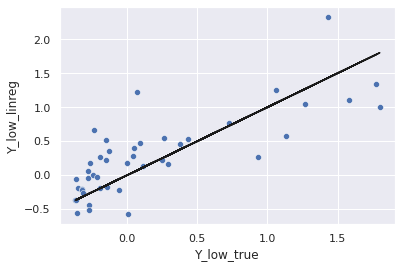

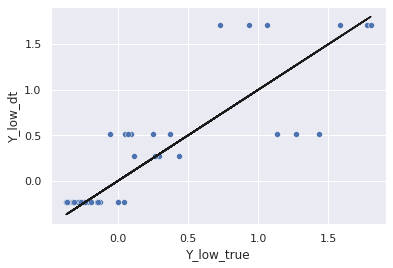

In [9]:
Y_low = Y[Y < 2]
X_low = X[Y < 2]

Y_low_linreg = linreg_model.predict(X_low)
Y_low_dt = dt_model.predict(X_low)


Y_low_arr = np.array([Y_low, Y_low_linreg, Y_low_dt]).T
Y_low_df = pd.DataFrame(data=Y_low_arr,
                    columns = ['Y_low_true', 'Y_low_linreg', 'Y_low_dt'])

sns.scatterplot(data = Y_low_df,
                x = 'Y_low_true',
                y = 'Y_low_linreg')
plt.plot(Y_low, Y_low, 'k-')

plt.figure()
sns.scatterplot(data = Y_low_df,
                x = 'Y_low_true',
                y = 'Y_low_dt')
plt.plot(Y_low, Y_low, 'k-')

print("Linear regression r2 = %.2f" % r2_score(Y_low, Y_low_linreg))
print("Decision Tree r2 = %.2f" % r2_score(Y_low, Y_low_dt))

Suddenly, the predictive capabilities of the two models flipped! This seems to solidify the idea that the linear regression model was able to adapt to outliers better than the decision tree model. At the same time, the decision tree model can generalize better to lower values of `dmg`. In a context such as ours (natural disaster assessment) it is crucial to account for outliers (counties with a lot of federal aid needed), thus the linear regression model is better suited for future predictions.

## Final Remarks

Where should we go from here?

Ideas:

- Investigate feature_importances_ from the decision tree model. While it may not be better suited for generalization, maybe we can learn something from how it weighed the predictors. Depending on what is found, we can try to modify the linear regression model.
- Incorporate data from hurricanes Harvey and Michael